<h1 align="center">
    <font size="24">
        <u>GROUP B</u>
    </font>

</h1>
<h1 align="center">
    <font size="15ç">
        <u> Black Friday Twitter Data Analysis</u>
    </font>

</h1>

![Alt Text](https://media.giphy.com/media/d8VjJgupHwJla1dhUz/giphy.gif)

This project is about analyzing the tweets injected during the period leading up to the start of the Christmas shopping season named *Black Friday*. The purpose was to get insight about the users behaviours during this time, and see if there is a clear pattern that indicates how not only companies, but also individual users try to profit from this period, increasing their presence in this social media.

<h1 align="center">
    <font size="15">
        <u>SETTING UP</u>
    </font>

</h1>

#### Installing Libraries:

In order to run this code most of you will have to install previsuly the next packages:

* pip install nltk
* pip install sklearn
* pip install folium
* pip install emojis

### Importing Libraries:

Lets first start with the libraries related to the start of the session in pyspark, where we will have to connect our machine to HDFS, and then import the necessary libraries to deal witht the __Big Data__ injected from twitter.

In [13]:
import findspark
findspark.init()

import pandas as pd
pd.set_option('display.max_colwidth', None)

import os
os.environ[''] = ''

import pyspark.sql.functions as sql
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

Now lets get into other important libraries that helped us to improve our sentiment analysis on the data:

In [14]:
import math
import numpy as np

#Text Scrapping
import emojis #Allows us to deal with emojis
import nltk #Natural Language Toolkit that helps us with the text scrapping
import re #Similar to the above, this is named "regex", which basically finds the pattern you indicate in the function
from sklearn.feature_extraction.text import CountVectorizer #Converts a collection of text documents into a matrix of token counts (very usefull in the word count)

#Plotting
import matplotlib.pyplot as plt #Visualization package
from PIL import Image #Read the byte array and converts it into an array of numbers
from io import BytesIO #Converts the image into a bytes array
from matplotlib.offsetbox import OffsetImage, AnnotationBbox #OffsetImage converts the array of numbers into a image readeable by matplotlib Creates an annotation box on the graph (in the form of an image)
from matplotlib.font_manager import FontProperties #Use to call a separate format, that allowed us to plot emojis on the graph

#Eliminate the red warnings
import warnings
warnings.filterwarnings('ignore')

#The next libraries allow us to plot the data gathered in the format of coordinates on to a map
import folium
from folium import IFrame

import requests #Requests is used to scrap data from the open web. In this work it was used to get the images from the accounts as a jpg format and add it to our graphs


### Connecting to Spark:

In [15]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
.config("spark.sql.warehouse.dir","hdfs://http://localhost:9000/warehouse")\
.config("spark.sql.legacy.timeParserPolicy","LEGACY")\
.config("spark.sql.sources.partitionOverwriteMode","dynamic")\
.enableHiveSupport()\
.getOrCreate()

### Creating the Dataframe:

To parse the twitter data, it is required to read the json file through a schema, which is provided by twitter for every developer account.

The data is stored as a json file in HDFS and it creates a new file depending on the datetime.

In [16]:
schema="""
created_at string,
id bigint,
id_str string,
text string,
[...]
"""
tweets_raw = spark.read.schema(schema)\
                       .option("recursiveFileLookup", "true")\
                       .json("hdfs://localhost:9000/datalake/")

tweets_raw = tweets_raw\
             .withColumn("created_at",sql.to_timestamp(sql.col("created_at"),"EEE MMM dd HH:mm:ss ZZZZZ yyyy"))\
             .withColumn("year",sql.year("created_at"))\
             .withColumn("dt",sql.to_date("created_at"))


<h1 align="center">
    <font size="15">
        <u>ANALYSIS</u>
    </font>

</h1>


The division of the analysis can be splitted into three major parts:
* Overall
* Users
* Content

### Total Tweets per Minute per Day:

The main purpose was to extract the number of tweets per minute, during our ingestion. To do so we used user defined functions
of Spark SQL (UDF) in a lambda function, using the library IntegerType(), converting the datetime into integers* that then can be grouped by.




<font size="0.3">*This could have also been done querying for hour and day, or minute per day. But there was also curiosity to know how to convert the dtypes of a column to another type.</font>

Text(0, 0.5, 'Tweets per minute')

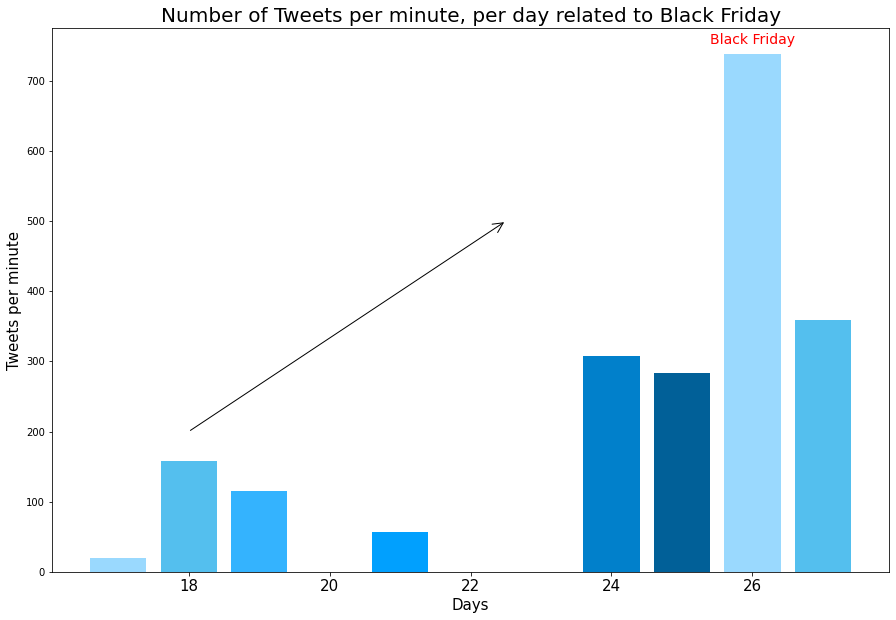

In [23]:
#We are doing a Spark user defined function which then will be used in the groupBy query of the 
#Database and convert the column "created_at" into hour/minute/day 
day = sql.udf(lambda x: x.day, IntegerType()) 
hour= sql.udf(lambda x: x.hour, IntegerType())
minute = sql.udf(lambda x: x.minute, IntegerType())

#Since this query would not return such a high amount of rows we can simply groupBy the integers,
#convert it into pandas and save the count table as "count"
tweet_per_minute = tweets_raw.groupBy(day("created_at").alias("day"), minute("created_at").alias("minute")).count().toPandas()
#Now we compute the rate per day 
tweet_per_minute = tweet_per_minute.groupby("day")["count"].sum()/tweet_per_minute.groupby("day")["minute"].count() 

#Matplotlib plot shows us how this rate behaves through time and see there is a clear upward trend while closing to Black Friday
plt.figure(figsize=(15, 10))
plt.bar(tweet_per_minute.index,tweet_per_minute, color= ['#9AD9FE','#54BFEE','#34B3FE', '#01A0FE', '#0180CB', '#016098'])
plt.annotate("", xy=(22.5, 500), xytext=(18, 200),arrowprops=dict(arrowstyle="->"), size=25)
plt.title("Number of Tweets per minute, per day related to Black Friday", size=20)
plt.xticks(size=15)
plt.xlabel("Days", size=15)
plt.text(25.40, 753, "Black Friday", size=14, color='red')
plt.ylabel("Tweets per minute", size=15)

### Number of Friends per User

In the code below we will identify the accounts that have the most friends (the accounts that follow the highest number of accounts), that have at least tweeted once during the ingestion time.

* The first step was to query the relevant data: *screen_name*, *friends_count*, *profile_image_url_https*; distinguishing the unique accounts, and sorting according to the *friends_count* on a descending order.
*  Then limit this query to the top 5 accounts and convert into a pandas DataFrame.
* After that, and mostly for plotting purposes, the different urls where requested with the _request_ library so that the images of the top 5 accounts could be plotted on the graph
* Finally, a horizontal bar chart was used to visualize the whole analysis.

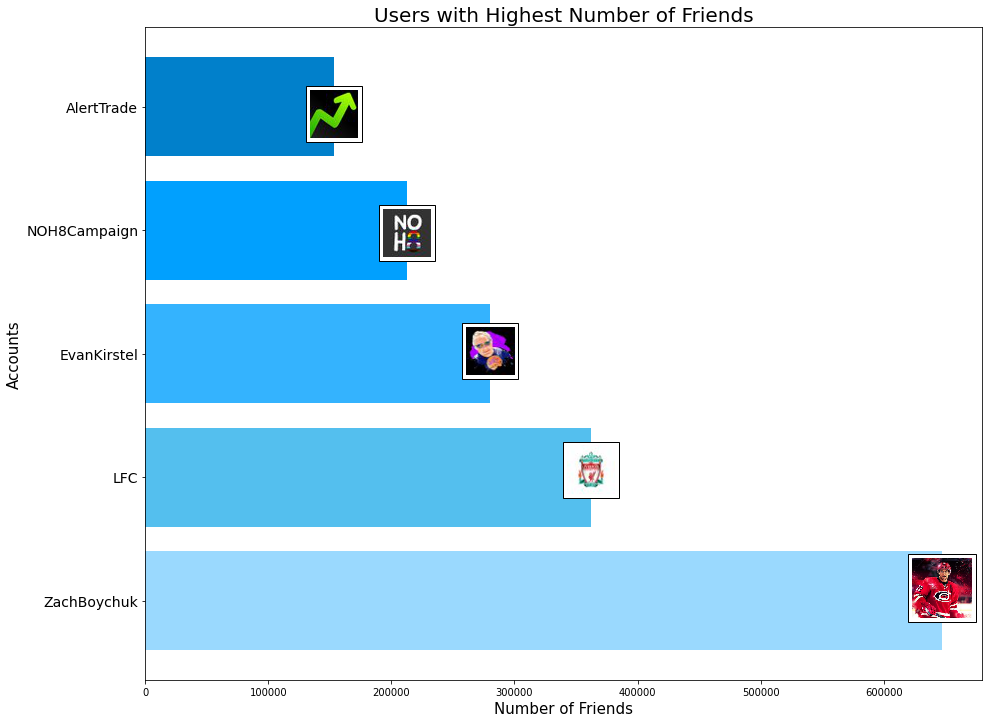

In [28]:
#Query the data to detect the distinct accounts with the highest amount of friends
top_users_friends = tweets_raw.select("user.screen_name","user.friends_count", "user.profile_image_url_https")\
    .distinct().sort(sql.col("user.friends_count").desc())\
    .limit(6).toPandas()
 
#Grouping by the distinct "screen_names" with the maximum friends value
top_users_friends = top_users_friends.groupby("screen_name", as_index=False).max().sort_values("friends_count", ascending=False) 
 
#For the length of the bars
friends_count = top_users_friends.friends_count.tolist()
 
#We convert the url image profile column to a list that could be scrapped with requests
url = top_users_friends["profile_image_url_https"].tolist()[1:]
url = ["https://pbs.twimg.com/profile_images/1465872598047338505/kq124tbq_400x400.jpg"] + url
 
#Sort from more to less friends
top_users_friends.sort_values("friends_count", ascending=False, inplace=True)

#Ready to be plotted!


#This code plots the data of the data
images = []
for i in url:
    images.append(plt.imread(i, "jpg"))
 
 
fig, ax = plt.subplots(figsize=(15, 12))
 
loc1 = 0.10
n = 0
 
for arr_lena in images[:6]:
 
    for j in range(len(friends_count)):
        if n == 0:
            v=0.15
        else:
            v=1
        imagebox = OffsetImage(arr_lena, zoom=v)
 
        ab = AnnotationBbox(imagebox, (friends_count[j+n], loc1))
 
        loc1 += 0.96
        ax.add_artist(ab)
        n += 1
        break
 
 
plt.draw()
plt.barh(top_users_friends["screen_name"][:6], top_users_friends["friends_count"][:6], color= ['#9AD9FE','#54BFEE','#34B3FE', '#01A0FE', '#0180CB', '#016098'])
plt.savefig('add_picture_matplotlib_figure.png',bbox_inches='tight')
plt.title("Users with Highest Number of Friends", size=20)
plt.yticks(size=14)
plt.xlabel("Number of Friends", size=15)
plt.ylabel("Accounts", size=15)
plt.show()

### Number of Followers per User

In the code below we will identify the accounts* who have the most followers (the number of accounts that follow this specific account), that have at least tweeted once during the ingestion time.

* The first step was to query the relevant data, grouping by: *screen_name*, *verified*, *profile_image_url_https*; distinguishing the unique tweets _id_, counting the number of tweets each account did during the week, and selecting the one whos according to the *followers_count* given the grouped attributes is the maximum, on a descending order.
*  Then limit this query to the top 15 accounts and convert into a pandas DataFrame.
* After that, and mostly for plotting purposes, the different urls where requested with the _request_ library so that the images of the top 5 accounts could be plotted on the graph
* Finally, a horizontal bar chart was used to visualize the whole analysis.

<font size="0.3">*An additional filter was also chosen, the verified accounts, since it might shrink the amount of data we are dealing with, and the probability that the ones with the highest amount of followers is actually verified is significant.</font>

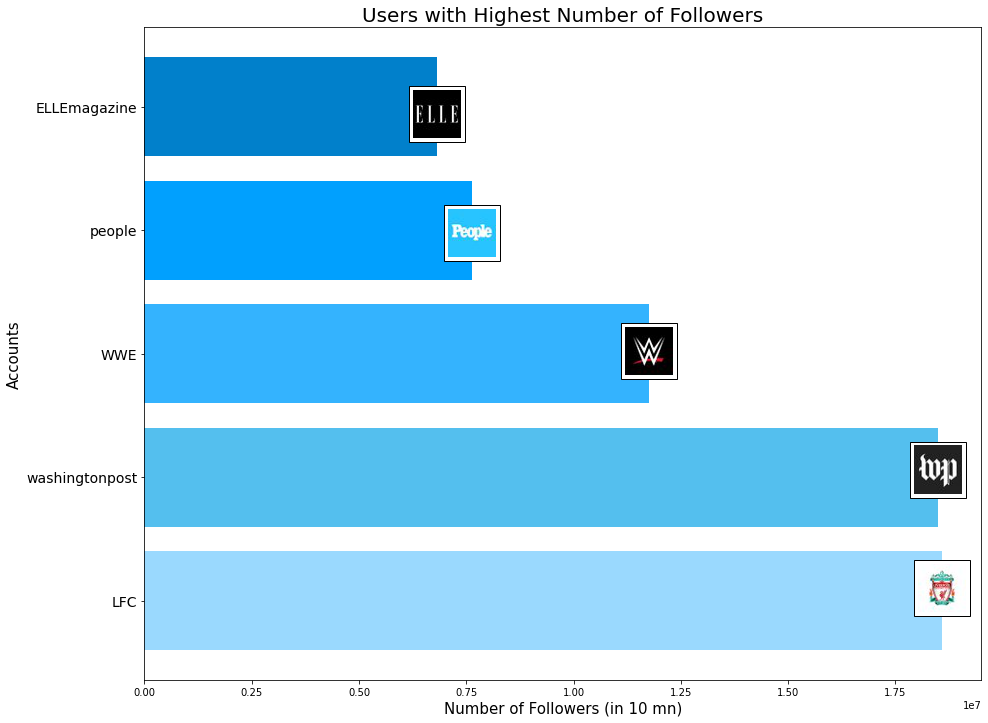

In [29]:
#Query the data to detect the distinct accounts with the highest amount of followers
rank = (tweets_raw
        .groupBy("user.screen_name","user.verified", "user.profile_image_url_https")
        .agg(
            count("id"),
            max("user.followers_count").alias("followers_count"))
        .orderBy(desc("followers_count"))).limit(15).toPandas()
 

#For the length of the bars. Notice this time we used another way to access a column in pandas, through ["col_name"], 
#in the friends section (2.4.) we used pd.DataFrame.col_name
url = rank["profile_image_url_https"].tolist()
 
#Sort from more to less followers
rank.sort_values("followers_count", ascending=False, inplace=True)
 
images = []
for i in rank["profile_image_url_https"]:
    images.append(plt.imread(i, "jpg"))
 
 
#Filter out the top 5 accounts with followers
foll = rank["followers_count"][:5].tolist()

#Ready to be plotted!
 
 
fig, ax = plt.subplots(figsize=(15, 12))
 
 
loc1 = 0.10
n = 0
for img in images[:5]:
 
    for j in range(len(foll)):
        imagebox = OffsetImage(img, zoom=1)
 
        ann_box = AnnotationBbox(imagebox, (foll[j+n], loc1))
 
        loc1 += 0.96
        ax.add_artist(ann_box)
        n += 1
        break
 
 
plt.draw()
plt.barh(rank["screen_name"][:5], rank["followers_count"][:5], color= ['#9AD9FE','#54BFEE','#34B3FE', '#01A0FE', '#0180CB', '#016098'])
plt.savefig('add_picture_matplotlib_figure.png',bbox_inches='tight')
plt.title("Users with Highest Number of Followers", size=20)
plt.yticks(size=14)
plt.xlabel("Number of Followers (in 10 mn)", size=15)
plt.ylabel("Accounts", size=15)
plt.show()

### Number of users per Day

The code seeks to show the percentage of unique users that actively posted __per day__. One user might post on each ingestion day, but there is evidence that the highest number of users interacted on the _Black Friday_.

Text(0, 0.5, 'Users per day (%)')

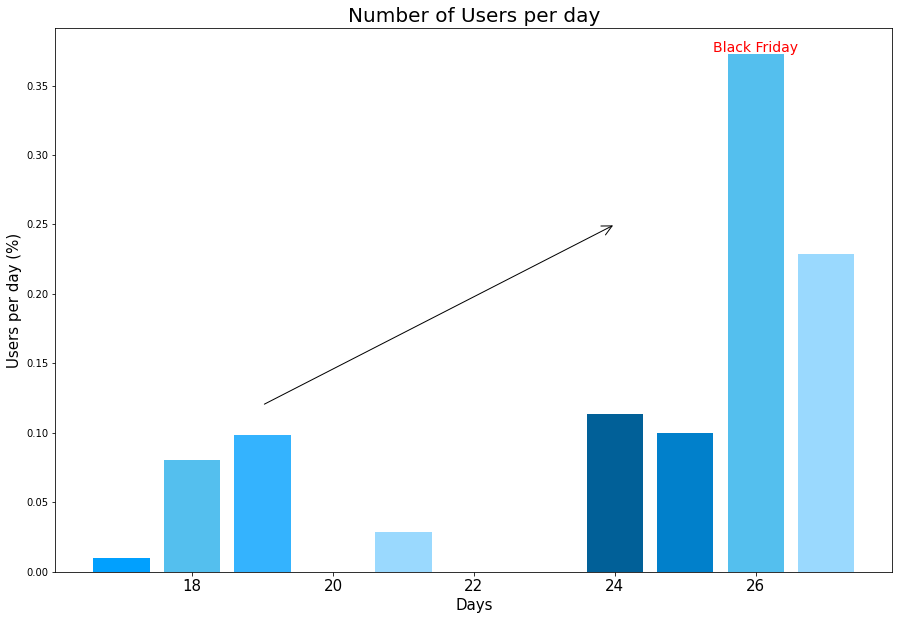

In [31]:
## Here we are creating a new variable "users" which will contain our dataframe with an additional 
#coloumn which will contain the day of the month which the tweet was posted
users = tweets_raw.withColumn("users", col("user"))\
                            .withColumn("day", sql.dayofmonth("created_at"))

## Now we are updating the variable "users" to be a dataframe grouping by "day" and counting the number of different users
#that posted on each day. Finally we update the count of users to be a ratio of number of users posting for each day 
#compared to the total number of distinct users
users = users.groupby("day").agg(sql.countDistinct('users.screen_name').alias("Number_users_per_day")).toPandas()
users.Number_users_per_day = users.Number_users_per_day / total_users


#We can will now plot day posted and ratio of users posting in a bar chart using matplotlib
plt.figure(figsize=(15, 10))
plt.bar(users.day,users.Number_users_per_day, color=['#9AD9FE','#54BFEE','#34B3FE', '#01A0FE', '#0180CB', '#016098'])
plt.annotate("", xy=(24, 0.25), xytext=(19, 0.12),arrowprops=dict(arrowstyle="->"), size=25)
plt.title("Number of Users per day", size=20)
plt.xticks(size=15)
plt.xlabel("Days", size=15)
plt.text(25.40, 0.374, "Black Friday", size=14, color='red')
plt.ylabel("Users per day (%)", size=15)

### Most Common Words:

The scope of the analysis is to find out what were the most used words during the _Black Friday_ ingestion week, and see if there are interesting insights that reveal the interests of the users in this specific period of time

The apporach of the code below:
* Create a function which makes use of the *nltk* library to process the words in english. After that *stemmer* function removes all morphological affixes from the words, to isolate them. Then convert the text into a matrix of token counts. Save it into a Series.
* Collect the text of the _text_ column. This might be inefficient when using millions of rows. In that case it will be required to configure the process driver to have enough memory to hold that much data (*%%configure -f { "driverMemory":"60G" }*)
* Now there is a need to build a __for loop__ which takes the not _null_ values and adds it into a new list which then will be converted into a dataframe.
* After that the pandas DataFrame is sorted in descending order, and through the _regex_ library numeric and the key words used for ingestion (black) will be excluded.
* This will be plotted on a barchart

Text(0.5, 1.0, 'Most used words')

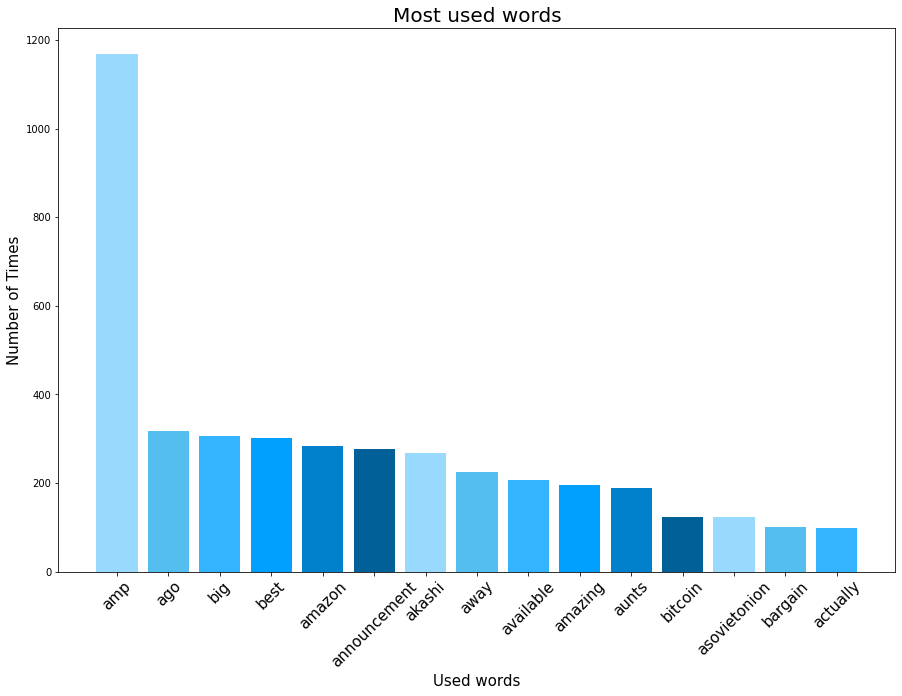

In [33]:
#Create a function which makes use of the *nltk* library to process the words in english. 
#After that *stemmer* function removes all morphological affixes from the words, to isolate it.
#Then convert the text into a matrix of token counts sklearns CountVectorizer() 
#Save it into a pandas Series.
def get_twitter_text(text):
    stemmer = nltk.stem.SnowballStemmer('english')
    paragraph = stemmer.stem(text)
    vectorizer = CountVectorizer(stop_words='english')
    counts = vectorizer.fit_transform([paragraph])
    counts = pd.Series(counts.toarray()[0], index=vectorizer.get_feature_names())
    return counts
 
#Collect the data from column (for efficiency purposes see descriptionn of the code)
texts = tweets_raw.select("text").collect()
texts = [i[0] for i in texts]
 

#Select the values which are not null and append it into a list that then can be converted into a dataframe
df = []
 
for i in range(len(texts)):
    try:
        df.append(get_twitter_text(texts[i]))
    except ValueError:
        continue
df = [[df[i].index[0],df[0][1]] for i in range(len(df))]
 
index = []
column = []
 
for i in range(len(df)):
    index.append(df[i][0])
    column.append(df[i][1])
 
df = pd.DataFrame(column, index=index, columns=['Value'])
 
grouped = df.groupby(df.index).sum().sort_values(['Value'], ascending=False)
l = df.groupby(df.index).sum().sort_values(['Value'], ascending=False).index
 
#Filter out with regex the numerical values (special the values that are not alphabetical) 
#and the ones which are not our key words i.e. "black".
n = []
for i in l:
    n.append(re.findall("^[a-zA-Z]*",i)[0])
 
h = []
for i in n:
    try:
        word = h.append(re.findall("^(?!black).*$",i)[0])
    except IndexError:
        continue

#Eliminate Nulls
m = {}
 
for i in h:
    try:
        m[i] = grouped.loc[i].values
    except KeyError:
        continue
 
most_used_words = pd.DataFrame(m).T
most_used_words = most_used_words.head(15)
 
#Plot the barchart of the top 15 used words
plt.figure(figsize=(15,10))
plt.bar(most_used_words.index, most_used_words[0], color= ['#9AD9FE','#54BFEE','#34B3FE', '#01A0FE', '#0180CB', '#016098'])
plt.xlabel("Used words", size=15)
plt.ylabel("Number of Times", size=15)
plt.xticks(rotation=45, size=15)
plt.title("Most used words", size=20)

### Reference of the most Retweeted Tweets:

The focus of this analysis was to identify which was the most referenced account during the injestion week.
* The approach was starting by filtering what were the most *quoted* tweets. This means that the *text* either is created or retweeted (in this case the text will be preceeded by a *RT*).
* The regex library, allows straighforwardly scrap the first reference of the filtered texts:
<h1 align="center">
    <font size="2">
       "RT <span style="color:blue">@Pyspark</span>  is the main framework when dealing with Big Data"
    </font>

</h1>

Text(0.5, 1.0, " '@' References of the most retweeted tweets")

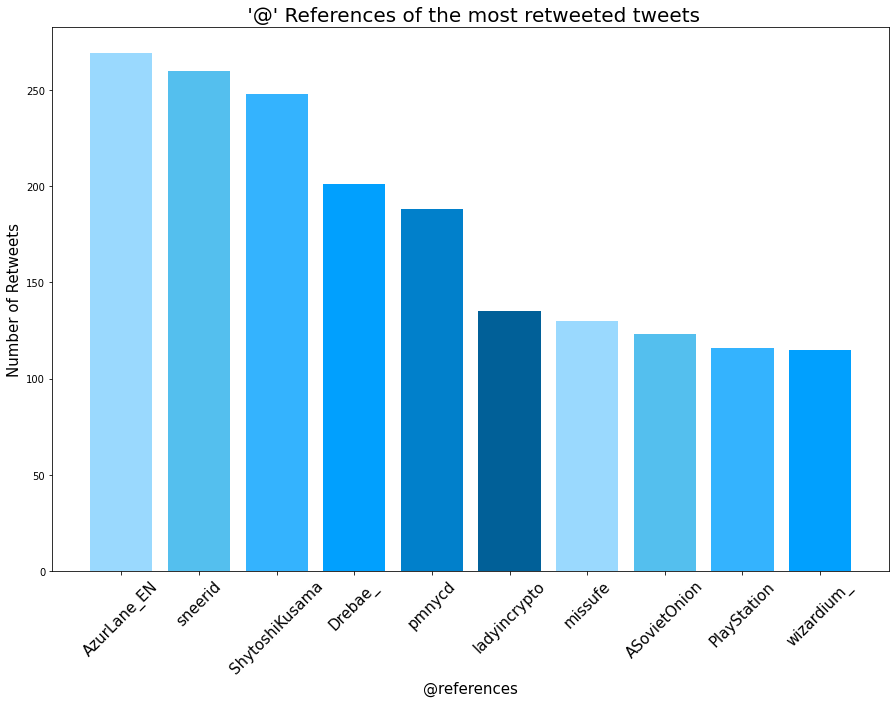

In [34]:
#Filter by text and count the number of "quote_count" each distinct text. Order "quote_count" in descending order.
#Then we only get the top 10 for the sake of optimization.
rank = tweets_raw.groupBy("text").agg(count("quote_count").alias("Tweet")).orderBy(desc("Tweet")).limit(10).toPandas()

#The code below uses regex to identify the references in each text. Since there is little amount of data, 
#it is possible to loop over the "text" column in the rank DataFrame and append the scrapped reference as a new column.
m = [re.findall("(?<=\@)(.*?)(?=\:)", i) for i in rank["text"]]
l = []
for i in m:
    l.append(i[0])

rank["insight"] = l

#Plotting the barchart
plt.figure(figsize=(15,10))
plt.bar(rank["insight"], rank["Tweet"], color= ['#9AD9FE','#54BFEE','#34B3FE', '#01A0FE', '#0180CB', '#016098'])
plt.xlabel("@references", size=15)
plt.ylabel("Number of Retweets", size=15)
plt.xticks(rotation=45, size=15)
plt.title(" '@' References of the most retweeted tweets", size=20)

### Tweets per Country Map:

The approach of the mapping helps to see where the users are supposed to be tweeting from.
For this analysis the coordinates attribute was used
Coordinates were saved in a table together with the country code (so that each location marker is labeled on the map).
Then using _folium_, this information can be illustrated on the map.
Notice a funny insight, there is one marker that is located at _Guam Island_ which is in the middle of the Pacific Ocean.
Another thing to point out is that, since the ingestion was mostly done on the rush hours of the American market, we see that most tweets were gathered with "US" as its _country code_.

In [37]:
#Select the tweets that don not have "None" values in the columns "coordinates" and "country_code", 
#since they will add no value to our analysis
tweet_sights = (tweets_raw
                .select(["coordinates.coordinates", "place.country_code"]))

#Now we extract the first value of the list of coordinates and save it as "latitude" 
#and the second value as a new column named "longitude"
tweet_sights = tweet_sights.select("coordinates",
        col("coordinates").getItem(0).alias("latitude"),
        col("coordinates").getItem(1).alias("longitude"),
        col("country_code"))

#Some rows had empty values which needed to be eliminated since they would add no value.
tweet_map = tweet_sights.where((col("country_code") != '') & ((col("latitude") != np.nan)))
rows = tweet_map.select(col("country_code").alias("country_code"), "longitude","latitude").toPandas()
locationlist = tweet_map.select("longitude", "latitude").collect()

#Finally we collect the two coordinates column into a list for display and loop over this list to add 
#for every iteration a new location marker, labeled with the country code (which was also previously converted to list)
map = folium.Map(location=[29.41670036315918, 0], zoom_start=2)
for point, key in zip(range(0, len(locationlist)), rows["country_code"].tolist()):
    folium.Marker(locationlist[point], popup=key).add_to(map)
map

<h1 align="center">
    <font size="15">
        <u>CONCLUSION</u>
    </font>

</h1>

To conclude there is clear evidence that the presence users and tweets clearly increase in number oximating to _Black Friday_

To conclude there is clear evidence that the activity on twitter related to the keywords: __#BlackFriday__, __BlackFriday__, __#blackfriday__, __blackfriday__, increased as _Black Friday_ weekend was approaching. 

In our analysis we covered the different users attributes that at least interacted once during this period. Those went from users per day rate to the verified and their friends and followers distribution.

Regarding the content of tweets, we found that there is a wide variety in the usage of characters, as the famous __emojis__, locations where these tweets actually have their origin; and also the length of the tweets.

Closer to _Black Friday_, the number of mentions "__@__" and references to discounts increased sharply.

Finally since this is a major event globally, through our data we were able to identify that many users took the opportunity to ride the _Black Friday wave_ to post unrelated topics aiming to gain attraction from a global audience.